# Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

**Sugerencias**
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

# Librerias

In [183]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

import gradio as gr
from scipy.special import softmax

# Datos

In [184]:
df = pd.read_csv('.\estudio_en_escarlata.txt', sep='/n', header=None, engine='python')
df.head(10)

,0
0,Estudio en Escarlata
1,Por
2,Arthur Conan Doyle
3,PRIMERA PARTE
4,(Reimpresión de las memorias
5,"de John H. Watson, doctor en medicina y oficia..."
6,Sanidad)
7,1.
8,Mr. Sherlock Holmes
9,En el año 1878 obtuve el título de doctor en m...


In [185]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3837


# Elegir el tamaño del contexto

In [186]:
# Paso 1: Cargamos el texto sin tokenizar desde el DataFrame
text = list(df.loc[:, 0])

# Paso 2: Segmentamos las oraciones en listas de palabras usando 'text_to_word_sequence' sin tokenización a índices
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Paso 3: Calculamos la longitud de cada secuencia (en palabras)
length_sentences = np.array([len(sentence) for sentence in segmented_sentences])

# Paso 4: Usamos el percentil 90 para determinar el tamaño máximo de contexto (sin tokenización)
max_context_size = int(np.percentile(length_sentences, 99) - 1)

# Mostramos el resultado
print(f'Max context size (sin tokenización): {max_context_size}')

for i, sentence in enumerate(segmented_sentences[:10]):  # Puedes ajustar el número de oraciones que deseas mostrar
    print(f"Oración {i+1}: {' '.join(sentence)}")

Max context size (sin tokenización): 16
Oración 1: estudio en escarlata
Oración 2: por
Oración 3: arthur conan doyle
Oración 4: primera parte
Oración 5: reimpresión de las memorias
Oración 6: de john h watson doctor en medicina y oficial retirado del cuerpo de
Oración 7: sanidad
Oración 8: 1
Oración 9: mr sherlock holmes
Oración 10: en el año 1878 obtuve el título de doctor en medicina por la universidad


In [187]:
# cada verso lo guardamos en una lista
text = list(df.loc[:, 0])

# Inicializamos el tokenizador de Keras y ajustamos al corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

# Convertimos el texto en secuencias de tokens
sequences = tokenizer.texts_to_sequences(text)

# Calculamos las longitudes de las secuencias
length_sentences = np.array([len(sequence) for sequence in sequences])

# Usamos el percentil 90 para determinar el máximo tamaño de contexto
max_context_size = int(np.percentile(length_sentences, 99) - 1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana

print(f'max_context_size: {max_context_size}')

# Aplicamos padding a todas las secuencias a partir del max_context_size
tokenized_sentences = pad_sequences(sequences, maxlen=max_context_size)

# Mostramos las primeras secuencias con padding
print(tokenized_sentences[10:20])

max_context_size: 16
[[   0    0    1  375 3358   50    7 3359    5   10 3360    4  175    1
  3361   44]
 [   0    0    0    0    1 3362   33  559    7    3 1979 3363  154  108
  1980  651]
 [   0    0    0    0 1393 3364    3 1086 3365    1 3366    1 3367    7
  3368    1]
 [   0    0    0    0    0  559 3369    3 1981    9  220   14   55 3370
     7    2]
 [   0    0 1982    6   44    1    4  301 3371    5   42 3372    2  456
  1983    1]
 [   0    0  748   17 3373    7 3374   20  279    2  510    1    4   16
  1984    5]
 [   0    0    0    0   16    4   45 3375   97 3376    2  872 3377  129
   352   31]
 [   0    0    0    0    0    1 1985  873 1087   26   51   73   15  353
   202 1088]
 [   0    0    7 3378 1394    5    2  652   38 3379   80 1986    6  874
     6    7]
 [   0    0    0 1987   14   86   18 1981   20 3380   26   23 3381    5
    21  187]]


# Organizando y estructurando el dataset

In [188]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [189]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [190]:
len(tok_sent)

3069

In [191]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [192]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [193]:
train_seqs.shape

(46035, 17)

In [194]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [195]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tokenizer.word_counts)
vocab_size

9067

# Modelos

## Callbacks

In [196]:
class PerplexityCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.perplexities = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            # Calcular la perplexity al final de cada época
            ppl = np.exp(logs['loss'])
            self.perplexities.append(ppl)
            print(f'\n Perplexity after epoch {epoch+1}: {ppl:.4f}')

## LSTM

In [197]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=30, input_shape=(max_context_size,)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(50, activation='relu'))
model.add(Dense(vocab_size+1, activation='softmax'))
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 16, 30)            272040    
                                                                 
 lstm_26 (LSTM)              (None, 16, 64)            24320     
                                                                 
 dropout_12 (Dropout)        (None, 16, 64)            0         
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dense_26 (Dense)            (None, 50)                3250      
                                                                 
 dense_27 (Dense)            (None, 9068)              462468    
                                                                 
Total params: 795102 (3.03 MB)
Trainable params: 7951

In [198]:
# Entrenar el modelo con el callback de perplexity
ppl_callback = PerplexityCallback()
hist = model.fit(X, y, epochs=200, batch_size=256, callbacks=[ppl_callback])

Epoch 1/200
179/180 [============================>.] - ETA: 0s - loss: 6.5208
 Perplexity after epoch 1: 677.8313
180/180 [==============================] - 8s 32ms/step - loss: 6.5189
Epoch 2/200
179/180 [============================>.] - ETA: 0s - loss: 5.7927
 Perplexity after epoch 2: 327.9182
180/180 [==============================] - 6s 31ms/step - loss: 5.7928
Epoch 3/200
155/180 [========================>.....] - ETA: 0s - loss: 5.5818

KeyboardInterrupt: 

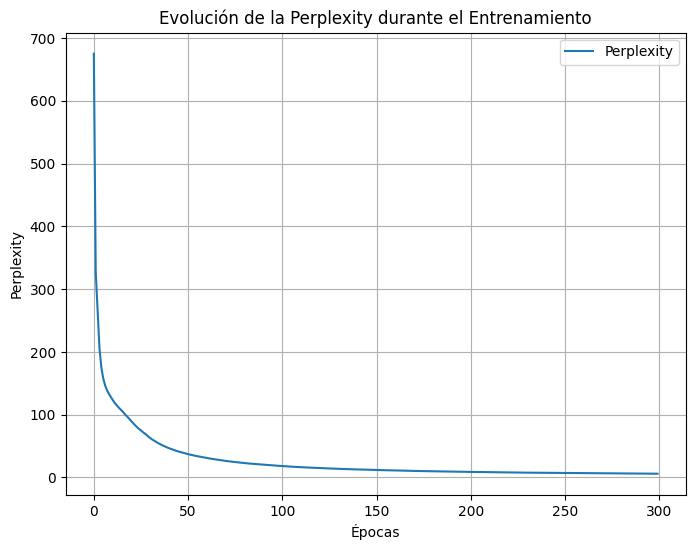

In [130]:
# Graficar la Perplexity por época
plt.figure(figsize=(8, 6))
plt.plot(ppl_callback.perplexities, label='Perplexity')
plt.title('Evolución de la Perplexity durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)
plt.show()

### Greedy Search

In [131]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [143]:
input_text='En el año 1878 obtuve'

generate_seq(model, tokenizer, input_text, max_length=max_context_size, n_words=2)

1/1 [==============================] - 0s 13ms/step


'En el año 1878 obtuve el título'

### Beam Search

In [160]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tokenizer.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tokenizer.sequences_to_texts([seq])

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input, temp):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp=temp)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp)

    return history_tokens

In [165]:
salidas = beam_search(model,num_beams=10,num_words=6,input="El señor Gregson, que había atendido", temp=0.1)

1/1 [==============================] - 0s 12ms/step


In [166]:
decode(salidas[0])

['el señor gregson que había atendido a la alocución dando muestras de']

# Conclusion

El modelo ha logrado reducir su pérdida de manera considerable, alcanzando una **perplexity** final de 5.9585, lo que indica que el modelo ha aprendido a generar secuencias de texto con un nivel razonable de confianza. Dado que la Perplexity mide cuántas palabras el modelo considera posibles en promedio en cada paso, un valor cercano a 6 sugiere que, en promedio, el modelo está considerando 6 palabras como posibles candidatas en cada predicción. 

- **Pérdida final**: La pérdida final de 1.7849 refleja que el modelo ha sido capaz de optimizar las probabilidades de predicción de las secuencias generadas. Aunque esta pérdida es relativamente baja, seguir afinando el modelo o ajustar hiperparámetros (como el tamaño del vocabulario, la arquitectura de la red, o el tamaño de la secuencia) podría mejorar aún más el rendimiento.

### Uso de Beam Search

En este ejercicio, se utilizó el algoritmo de **Beam Search** para mejorar la calidad de las secuencias generadas. A diferencia de una búsqueda codiciosa (greedy), Beam Search permite explorar múltiples secuencias a lo largo de la generación del texto, manteniendo las más probables en cada paso. Este enfoque ha permitido al modelo generar secuencias con mayor calidad, ya que considera una variedad más amplia de opciones antes de tomar decisiones finales.

### Posibles mejoras
- Se podrían explorar **variantes del Beam Search**, como **Diverse Beam Search**, para aumentar la diversidad en las secuencias generadas.
- Ajustar el **tamaño del beam** podría mejorar la calidad de las secuencias generadas. Así tambien encontrar una temperatura ideal segun la utilidad que se le quiera dar
- Probar con ajustes en el modelo, como la regularización o la arquitectura de la red, para intentar reducir aún más la perplexity y la pérdida.